In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score,classification_report,ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin


In [4]:
#Import the dataset
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
sample_submission = pd.read_csv('../Data/sample_submission.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
# Define feature matrix X and target vector y
X = train.drop(['is_promoted','employee_id'], axis=1)
y = train['is_promoted']

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   region                54808 non-null  object 
 2   education             52399 non-null  object 
 3   gender                54808 non-null  object 
 4   recruitment_channel   54808 non-null  object 
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  50684 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   KPIs_met >80%         54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 5.0+ MB


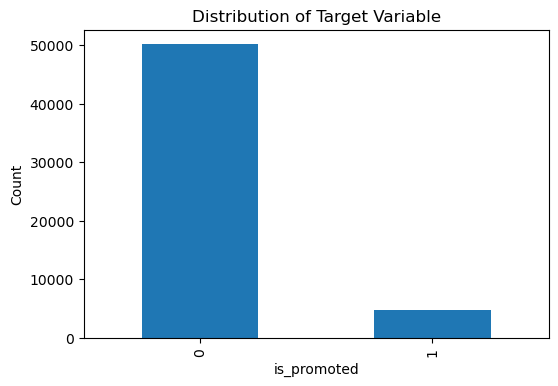

In [7]:
#Plot and check the distribution of target variable
plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('is_promoted')
plt.ylabel('Count') 
plt.show()


* Majority of data in target variable is as Not Promoted (0) -> 50k
* Around 4.6k data in target variable is as Promoted
* We might need to sample the data mostly Undersampling, as we need to predict promotion eligible candidate

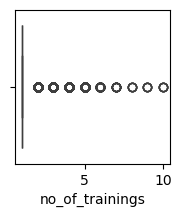

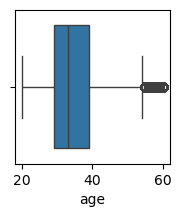

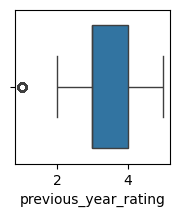

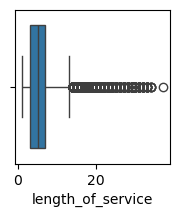

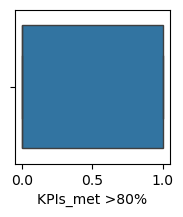

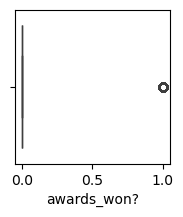

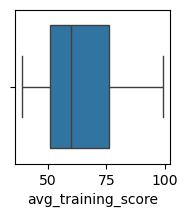

In [41]:
# Check the distribution and outliers of the numerical features
for col in X.select_dtypes(exclude=object).columns:
    plt.figure(figsize=(2,2))
    sns.boxplot(x=X[col])
    plt.show()

* Outliers which we have in our data is minimal and can be ignored

<Axes: >

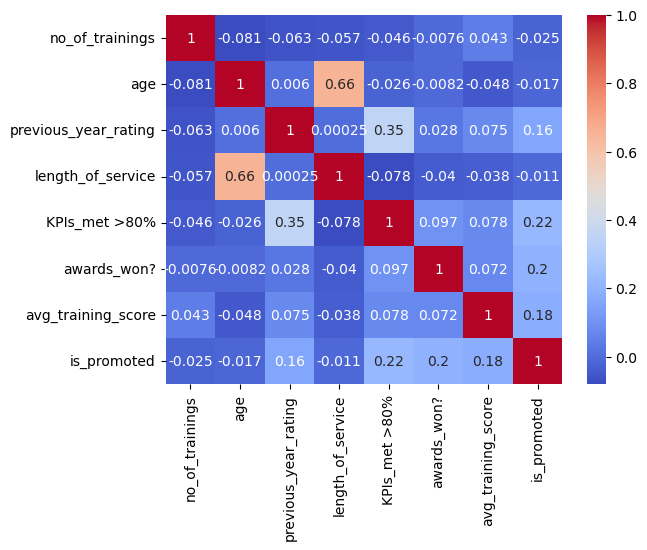

In [9]:
# Check the corelation of numerical features with target variable
numerical_features_corr = train.select_dtypes(exclude=object).columns
sns.heatmap(train[numerical_features_corr.drop('employee_id')].corr(), annot=True, cmap='coolwarm')

* KPIs met > 80% has higher correlation followed by awads_won

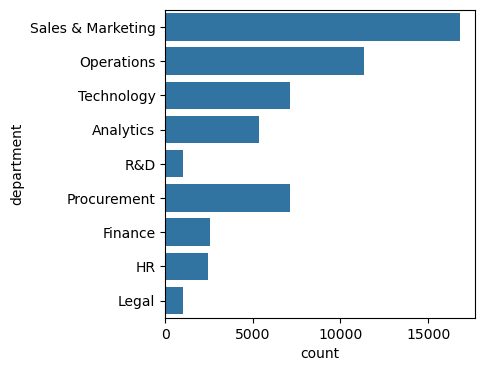

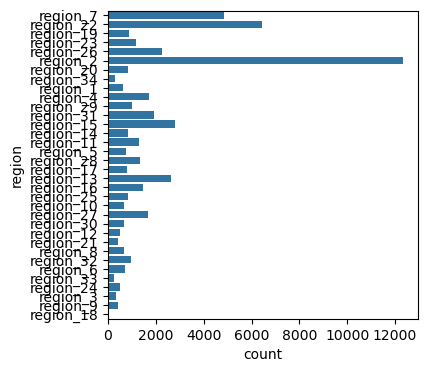

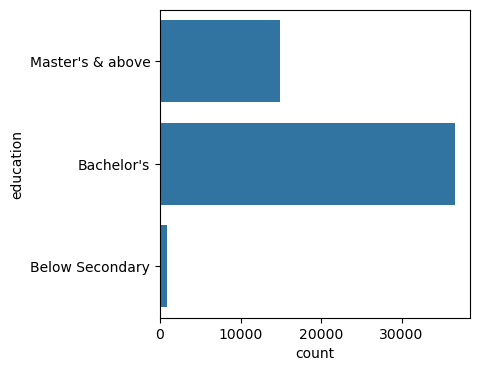

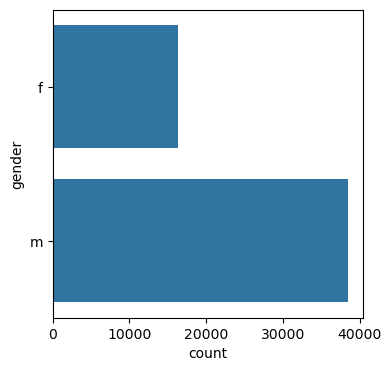

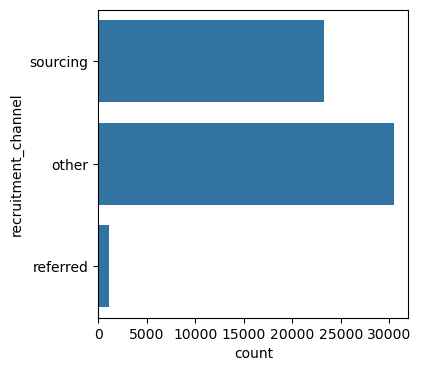

In [42]:
# Check the frequency of categorical features
for col in X.select_dtypes(include=object).columns:
    plt.figure(figsize=(4,4))
    sns.countplot(y=X[col])
    plt.show()
    

* Apart from region rest of the category has less distinct values
* In education & recuirment_channel we can see the data frequency for referred and Below Secondary is very less

In [11]:
# Check if we have any missing or null values in the dataset
(X.isna().sum()[X.isna().sum()>0]/X.shape[0]*100).sort_values()

education               4.395344
previous_year_rating    7.524449
dtype: float64

* In education we have around 4.3% of data as null which can be replaced with global mode during pipline creation
- previous_year_rating:
    * we have around 7.5% of data as null
    * And we can see only null values for employees whose length_of_service is 1, that means they are not part of last year appraisal cycle
    * So computing those value with global median/mean is not appropirate
    * rather we can update the value as 0 and create a new feature which help indicating if 0 is present that employee is new joinee

In [12]:
def evaluate_model(y_true, y_pred, y_proba):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_proba))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=[1, 0],
    yticklabels=[1, 0])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
class FeatureEngineering (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Example feature engineering: Create a new feature 'total_training_score'
        X = X.copy()
        X['new_joinee'] = X['previous_year_rating'].isna().astype(int)
        X['previous_year_rating'] = X['previous_year_rating'].fillna(0)
        return X

In [14]:
# Segregate the categorical columns & numerical columns
categorical_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel']
numerical_cols = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'new_joinee']

In [15]:
# Split the data into training and validation sets
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
categorical_pipeline = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]
)

In [17]:
# Preprocessing pipeline for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_processing', categorical_pipeline, categorical_cols),
        ('scaler', StandardScaler(), numerical_cols)
    ]
)

In [18]:
# Model Builder
model_pipeline = Pipeline(
    steps= [
        ('feature_engineering', FeatureEngineering()),
        ('preprocessor', preprocessor),
        ('undersampler', RandomOverSampler()),
        ('model', LogisticRegression())
    ]
)

model_pipeline

,steps,"[('feature_engineering', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_processing', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
model_pipeline.fit(train_x, train_y)

,steps,"[('feature_engineering', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_processing', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy: 0.7687588377503078
Precision: 0.2442876613485128
Recall: 0.810372340425532
F1 Score: 0.3754081192632292
ROC AUC Score: 0.8774920855002172

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86     40086
           1       0.24      0.81      0.38      3760

    accuracy                           0.77     43846
   macro avg       0.61      0.79      0.62     43846
weighted avg       0.91      0.77      0.82     43846



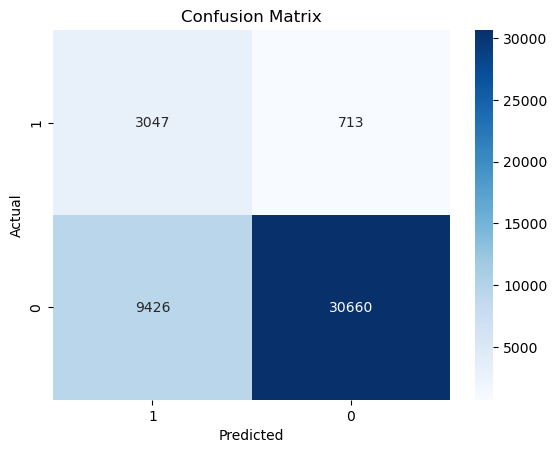

In [20]:
y_pred = model_pipeline.predict(train_x)
y_proba = model_pipeline.predict_proba(train_x)[:, 1]
evaluate_model(train_y, y_pred, y_proba)

Accuracy: 0.769202700237183
Precision: 0.24302915082382762
Recall: 0.8447136563876652
F1 Score: 0.37746062992125984
ROC AUC Score: 0.8814859012434177

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86     10054
           1       0.24      0.84      0.38       908

    accuracy                           0.77     10962
   macro avg       0.61      0.80      0.62     10962
weighted avg       0.92      0.77      0.82     10962



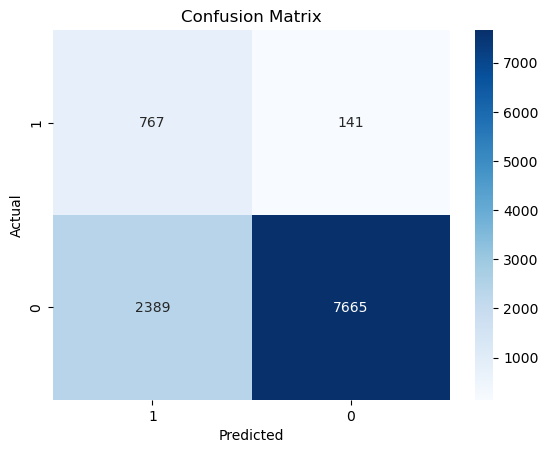

In [21]:
y_pred = model_pipeline.predict(test_x)
y_proba = model_pipeline.predict_proba(test_x)[:, 1]
evaluate_model(test_y, y_pred, y_proba)

In [22]:
# Try out different models like DecisionTree, RandomForest, AdaBoost, XGBoost
model_params = [
    {'model': [LogisticRegression()]},
    {'model': [DecisionTreeClassifier()]},
    {'model': [RandomForestClassifier()]},
    {'model': [AdaBoostClassifier()]},
    {'model': [GradientBoostingClassifier()]},
    {'model': [XGBClassifier()]}
]

gridSearch = GridSearchCV(estimator=model_pipeline,
                          param_grid=model_params,cv=5, scoring='f1')

gridSearch.fit(train_x, train_y)

,estimator,Pipeline(step...egression())])
,param_grid,"[{'model': [LogisticRegression()]}, {'model': [DecisionTreeClassifier()]}, ...]"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat_processing', ...), ('scaler', ...)]"


In [23]:
result_data_frame = pd.DataFrame(gridSearch.cv_results_)
result_data_frame[['param_model', 'params','rank_test_score']]

,param_model,params,rank_test_score
0,LogisticRegression(),{'model': LogisticRegression()},4
1,DecisionTreeClassifier(),{'model': DecisionTreeClassifier()},2
2,RandomForestClassifier(),{'model': RandomForestClassifier()},1
3,AdaBoostClassifier(),{'model': AdaBoostClassifier()},6
4,GradientBoostingClassifier(),{'model': GradientBoostingClassifier()},5
5,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",3


Accuracy: 0.9997491219267436
Precision: 0.9970830018562715
Recall: 1.0
F1 Score: 0.9985393706015138
ROC AUC Score: 0.9999995521596653

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       1.00      1.00      1.00      3760

    accuracy                           1.00     43846
   macro avg       1.00      1.00      1.00     43846
weighted avg       1.00      1.00      1.00     43846



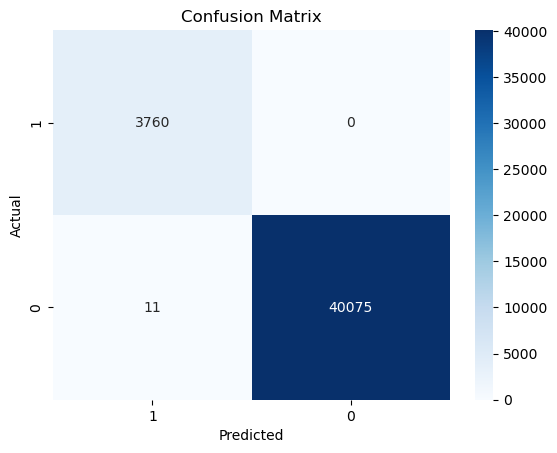

In [24]:
best_model = gridSearch.best_estimator_
y_pred = best_model.predict(train_x)
y_proba = best_model.predict_proba(train_x)[:, 1]
evaluate_model(train_y, y_pred, y_proba)

Accuracy: 0.928388980113118
Precision: 0.6189555125725339
Recall: 0.3524229074889868
F1 Score: 0.44912280701754387
ROC AUC Score: 0.8829988217808853

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     10054
           1       0.62      0.35      0.45       908

    accuracy                           0.93     10962
   macro avg       0.78      0.67      0.71     10962
weighted avg       0.92      0.93      0.92     10962



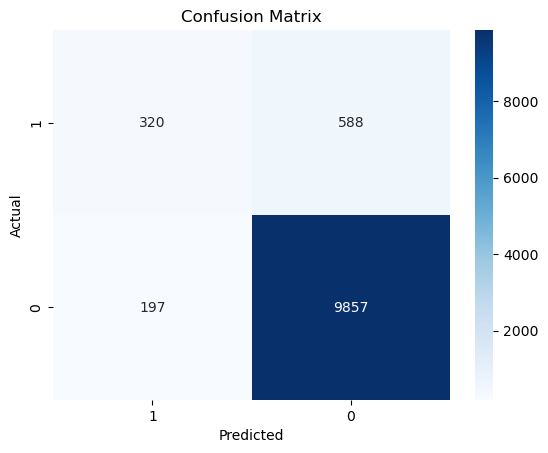

In [25]:
best_model = gridSearch.best_estimator_
y_pred = best_model.predict(test_x)
y_proba = best_model.predict_proba(test_x)[:, 1]
evaluate_model(test_y, y_pred, y_proba)

* Random Forest Classifier is performing well in Train and not in Test clearly shows its overfitting

In [26]:
# Check how the third ranked model XGBClassifier performs in train and test data
third_ranked_model = result_data_frame.loc[result_data_frame['rank_test_score'] == 3, 'param_model'].values[0]
model_pipeline.set_params(model=third_ranked_model)
model_pipeline.fit(train_x, train_y)

,steps,"[('feature_engineering', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_processing', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy: 0.8516170232176253
Precision: 0.3629466959472949
Recall: 0.9670212765957447
F1 Score: 0.5277979387429235
ROC AUC Score: 0.9682927185275062

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91     40086
           1       0.36      0.97      0.53      3760

    accuracy                           0.85     43846
   macro avg       0.68      0.90      0.72     43846
weighted avg       0.94      0.85      0.88     43846



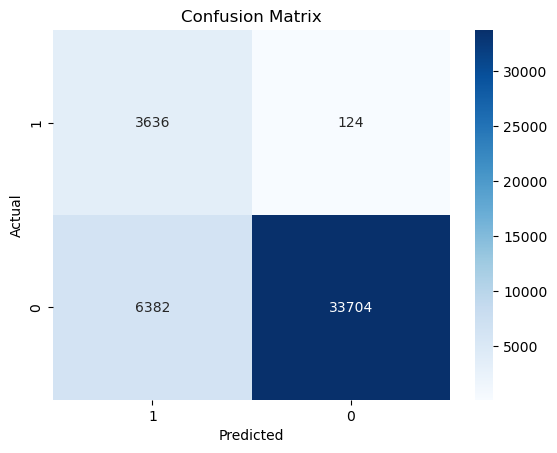

In [27]:
y_pred = model_pipeline.predict(train_x)
y_proba = model_pipeline.predict_proba(train_x)[:, 1]
evaluate_model(train_y, y_pred, y_proba)

Accuracy: 0.8180076628352491
Precision: 0.27752762996316005
Recall: 0.7466960352422908
F1 Score: 0.40465532676812893
ROC AUC Score: 0.8991703063369698

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89     10054
           1       0.28      0.75      0.40       908

    accuracy                           0.82     10962
   macro avg       0.63      0.79      0.65     10962
weighted avg       0.92      0.82      0.85     10962



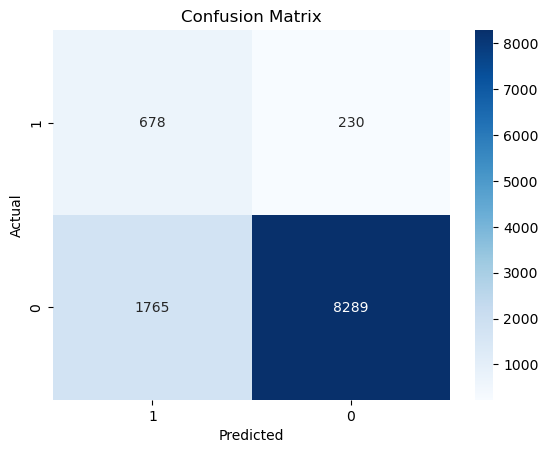

In [28]:
y_pred = model_pipeline.predict(test_x)
y_proba = model_pipeline.predict_proba(test_x)[:, 1]
evaluate_model(test_y, y_pred, y_proba)

* XGBoostClassifier Train and Test data F1 score are nearer and it doesn't seems to overfit
* But still the F1 score of test data of XGBoostClassifier is closer to the F1 score of Random Forest

In [29]:
# Try hyperparameter tuning on the XGBClassifier and RandomForestClassifier models to improve performance
model_params_rf = {
    'model': [RandomForestClassifier()],
    'model__max_depth': [5, 7, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 3],
    'model__max_features': ['sqrt', 0.5]
}

model_params_tuning_RF = RandomizedSearchCV(estimator=model_pipeline, param_distributions=model_params_rf, n_iter=50, n_jobs=-1, cv=5, scoring='f1')

model_params_tuning_RF.fit(train_x, train_y)

c:\Users\NATARAJ\.conda\envs\ml-hackathon\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model': [RandomForestClassifier()], 'model__max_depth': [5, 7, ...], 'model__max_features': ['sqrt', 0.5], 'model__min_samples_leaf': [1, 3], ...}"
,n_iter,50
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [30]:
model_params = [
    {'model': [XGBClassifier()],
     'model__n_estimators': [300, 400, 500, 600],
     'model__learning_rate': [0.01, 0.1, 0.2],
     'model__max_depth': [2, 3, 5, 7],
     'model__subsample': [0.5,0.6, 0.8, 0.9],
     'model__min_child_weight': [4, 6, 8, 10],
     'model__gamma': [0.1, 0.2, 0.3],
     'model__colsample_bytree': [0.3, 0.4, 0.5, 0.7],
     'model__reg_alpha': [0, 0.01, 0.1, 0.6, 0.8],
     'model__reg_lambda': [1, 1.5, 2, 5, 8],
     'model__scale_pos_weight': [1, 3, 5, 7, 9]
     }
]


model_params_tuning_XG = RandomizedSearchCV(estimator=model_pipeline, param_distributions=model_params, n_iter=50, n_jobs=-1, cv=5, scoring='f1')

model_params_tuning_XG.fit(train_x, train_y)

,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"[{'model': [XGBClassifier...ree=None, ...)], 'model__colsample_bytree': [0.3, 0.4, ...], 'model__gamma': [0.1, 0.2, ...], 'model__learning_rate': [0.01, 0.1, ...], ...}]"
,n_iter,50
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


Accuracy: 0.9358892487342061
Precision: 0.5942028985507246
Recall: 0.7960106382978723
F1 Score: 0.6804592474707286
ROC AUC Score: 0.9716111424267613

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     40086
           1       0.59      0.80      0.68      3760

    accuracy                           0.94     43846
   macro avg       0.79      0.87      0.82     43846
weighted avg       0.95      0.94      0.94     43846



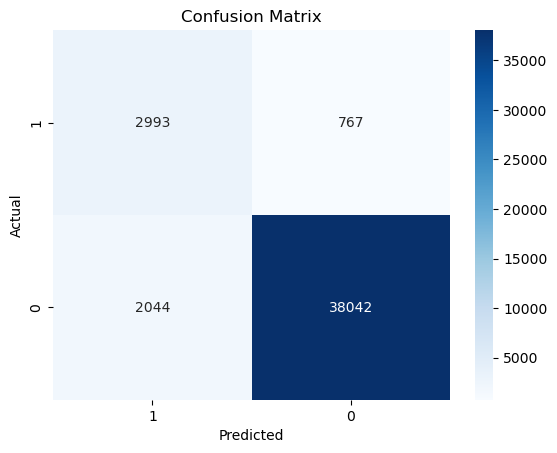

Accuracy: 0.9054004743659916
Precision: 0.442152466367713
Recall: 0.5429515418502202
F1 Score: 0.48739495798319327
ROC AUC Score: 0.9061948189030338

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     10054
           1       0.44      0.54      0.49       908

    accuracy                           0.91     10962
   macro avg       0.70      0.74      0.72     10962
weighted avg       0.92      0.91      0.91     10962



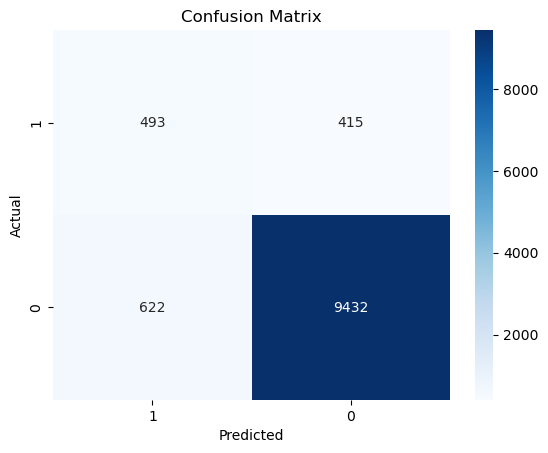

In [38]:
hyper_tuned_model_XG = model_params_tuning_XG.best_estimator_

# y_train_pred_XG = hyper_tuned_model_XG.predict(train_x)
y_train_proba_XG = hyper_tuned_model_XG.predict_proba(train_x)[:, 1]    
y_train_pred_XG = (y_train_proba_XG >= 0.69).astype(int)
evaluate_model(train_y, y_train_pred_XG, y_train_proba_XG)

# y_test_pred_XG = hyper_tuned_model_XG.predict(test_x)
y_test_proba_XG = hyper_tuned_model_XG.predict_proba(test_x)[:, 1]  
y_test_pred_XG = (y_test_proba_XG >= 0.69).astype(int)  
evaluate_model(test_y, y_test_pred_XG, y_test_proba_XG)

Accuracy: 0.9997491219267436
Precision: 0.9970830018562715
Recall: 1.0
F1 Score: 0.9985393706015138
ROC AUC Score: 0.999999538890322

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       1.00      1.00      1.00      3760

    accuracy                           1.00     43846
   macro avg       1.00      1.00      1.00     43846
weighted avg       1.00      1.00      1.00     43846



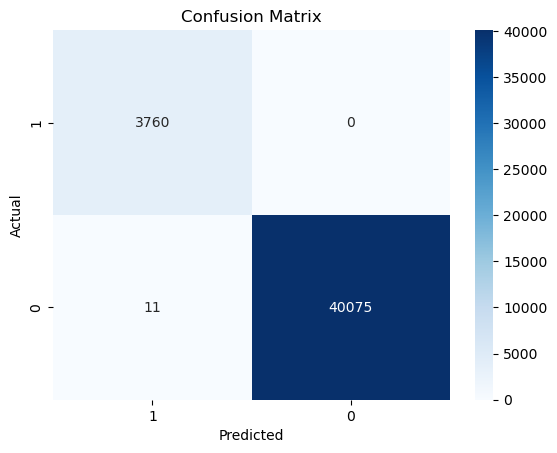

Accuracy: 0.9386060937785076
Precision: 0.8254847645429363
Recall: 0.32819383259911894
F1 Score: 0.46966115051221435
ROC AUC Score: 0.8872475745511683

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     10054
           1       0.83      0.33      0.47       908

    accuracy                           0.94     10962
   macro avg       0.88      0.66      0.72     10962
weighted avg       0.93      0.94      0.93     10962



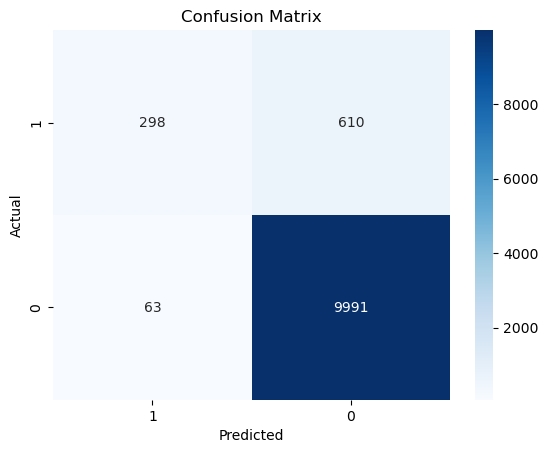

In [39]:
hyper_tuned_model_RF = model_params_tuning_RF.best_estimator_

y_train_proba_RF = hyper_tuned_model_RF.predict_proba(train_x)[:, 1]    
y_train_pred_RF = (y_train_proba_RF >= 0.69).astype(int)
evaluate_model(train_y, y_train_pred_RF, y_train_proba_RF)

y_test_proba_RF = hyper_tuned_model_RF.predict_proba(test_x)[:, 1]   
y_test_pred_RF = (y_test_proba_RF >= 0.69).astype(int) 
evaluate_model(test_y, y_test_pred_RF, y_test_proba_RF)

In [33]:
# Get the params of XGBClassifier
model_params_tuning_XG.best_params_

{'model__subsample': 0.8,
 'model__scale_pos_weight': 1,
 'model__reg_lambda': 2,
 'model__reg_alpha': 0.01,
 'model__n_estimators': 500,
 'model__min_child_weight': 8,
 'model__max_depth': 7,
 'model__learning_rate': 0.1,
 'model__gamma': 0.1,
 'model__colsample_bytree': 0.3,
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None

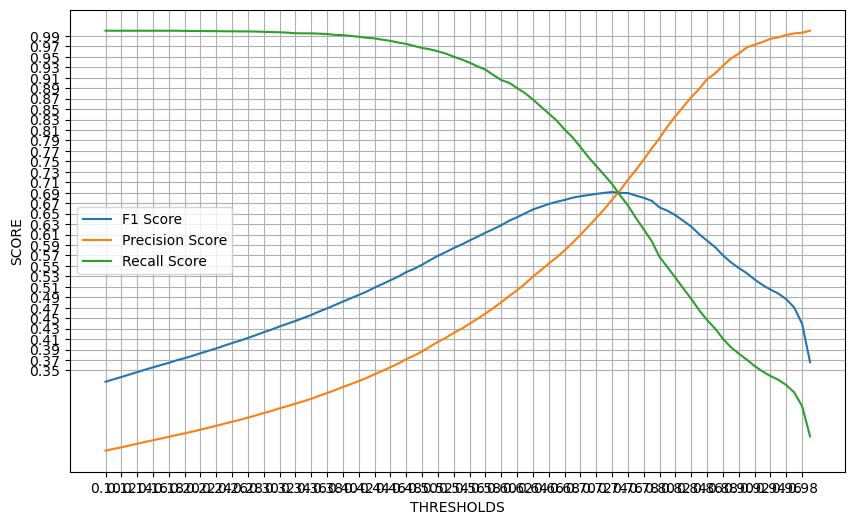

In [34]:
# Find the optimal threshold for final model evaluation
thresholdrange = np.arange(0.1, 1.0, 0.01)
f1scorerange = []
precisionrange = []
recallrange = []

for threshold in thresholdrange:
    train_pred_threshold = (y_train_proba_XG>= threshold).astype(int)
    f1score = f1_score(train_y, train_pred_threshold)
    f1scorerange.append(f1score)
    precisionscore = precision_score(train_y, train_pred_threshold)
    precisionrange.append(precisionscore)
    recallscore = recall_score(train_y, train_pred_threshold)
    recallrange.append(recallscore)

plt.figure(figsize=(10,6))
plt.plot(thresholdrange, f1scorerange, label='F1 Score')
plt.plot(thresholdrange, precisionrange, label='Precision Score')
plt.plot(thresholdrange, recallrange, label='Recall Score')
plt.xticks(np.arange(0.1, 1.0, 0.02))
plt.yticks(np.arange(0.35, 1.0, 0.02))
plt.xlabel('THRESHOLDS')
plt.ylabel('SCORE')
plt.grid(True)
plt.legend()
plt.show()



In [35]:
# Solution Submit For Hackathon
sample_submission

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0


In [40]:
test_proba = hyper_tuned_model_XG.predict_proba(test.drop('employee_id', axis=1))[:, 1]
sample_submission['is_promoted'] = (test_proba >= 0.7).astype(int)
sample_submission.to_csv('../SolutionSubmission/XG_Threshold_Upd6_Submission.csv', index=False)   

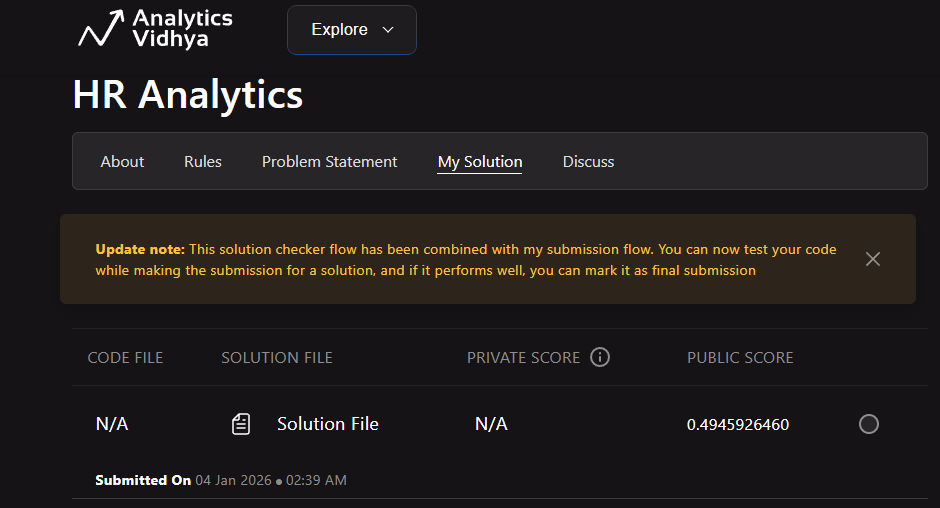